In [1]:
import os
import random
import ccxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.layers import Input, Bidirectional, LSTM, GRU, Dense, \
    Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

2024-11-24 22:58:57.194939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732510737.205713   14770 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732510737.209011   14770 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 22:58:57.220235: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Función para cargar datos existentes.
def load_data(symbol):
    file_path = os.path.join(data_dir, f"{symbol.replace('/', '_')}.csv")
    if os.path.exists(file_path):
        return pd.read_csv(file_path, parse_dates=['timestamp'],
            index_col='timestamp')
    return pd.DataFrame()

# Función para guardar los datos actualizados.
def save_data(symbol, df, data_dir):
    file_path = os.path.join(data_dir, f"{symbol.replace('/', '_')}.csv")
    df.to_csv(file_path)

In [4]:
# Obtener datos de varias criptomonedas.
exchange = ccxt.binance()
symbols = ['BTC/USDT', 'ETH/USDT', 'XRP/USDT', 'LTC/USDT', 'ADA/USDT']
timeframe = '1m'
limit = 1000
data_dir = "files_minute"
os.makedirs(data_dir, exist_ok=True)
since = exchange.parse8601(
    (pd.to_datetime("today") - pd.DateOffset(months=3)).strftime(
        '%Y-%m-%dT%H:%M:%SZ'))

# Procesar cada criptomoneda.
dataframes = []
total_symbols = len(symbols)

for idx, symbol in enumerate(symbols, start=1):
    print(f"Procesando {symbol} ({idx}/{total_symbols})...")

    # Cargar datos existentes.
    existing_data = load_data(symbol)

    # Determinar desde dónde extraer nuevos datos.
    last_timestamp = existing_data.index.max() \
        if not existing_data.empty else None
    new_since = exchange.parse8601(last_timestamp.isoformat()) \
        if last_timestamp else since
    
    all_ohlc = []
    while False:
        try:
            ohlc = exchange.fetch_ohlcv(symbol, timeframe, new_since, limit)

            # Convertir a DataFrame.
            new_data = pd.DataFrame(ohlc,
                columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            new_data['timestamp'] = pd.to_datetime(new_data['timestamp'], unit='ms')
            new_data.set_index('timestamp', inplace=True)

            # Agregar datos nuevos a la lista.
            all_ohlc.append(new_data)

            # Actualizar el nuevo "since" para la siguiente solicitud.
            new_since = ohlc[-1][0] + 1

            # Si recibimos menos de 1000 datos, alcanzamos el final.
            if len(ohlc) < limit:
                break
        except Exception as e:
            print(f"Error al obtener datos de {symbol}: {e}")

    # Combinar datos nuevos con los existentes.
    combined_data = existing_data
    # combined_data = pd.concat(all_ohlc).drop_duplicates() \
    #     .sort_index()
    # save_data(symbol, combined_data, data_dir)

    # Guardar en memoria el precio de cierre del DataFrame combinado.
    dataframes.append(combined_data[['close']].rename(
        columns={'close': symbol.split('/')[0]}))

# Concatenar los precios de cierre en un solo DataFrame.
df_combined = pd.concat(dataframes, axis=1).dropna()
print(df_combined.head())

Procesando BTC/USDT (1/5)...
Procesando ETH/USDT (2/5)...
Procesando XRP/USDT (3/5)...
Procesando LTC/USDT (4/5)...
Procesando ADA/USDT (5/5)...
                          BTC      ETH     XRP    LTC     ADA
timestamp                                                    
2024-08-24 21:56:00  63703.98  2744.64  0.6095  66.25  0.3899
2024-08-24 21:57:00  63663.66  2743.95  0.6091  66.14  0.3896
2024-08-24 21:58:00  63561.86  2734.41  0.6065  65.99  0.3882
2024-08-24 21:59:00  63612.37  2739.21  0.6081  66.15  0.3893
2024-08-24 22:00:00  63733.00  2747.17  0.6099  66.43  0.3909


In [5]:
df_differences = df_combined.diff().dropna()
print(df_differences.head())

                        BTC   ETH     XRP   LTC     ADA
timestamp                                              
2024-08-24 21:57:00  -40.32 -0.69 -0.0004 -0.11 -0.0003
2024-08-24 21:58:00 -101.80 -9.54 -0.0026 -0.15 -0.0014
2024-08-24 21:59:00   50.51  4.80  0.0016  0.16  0.0011
2024-08-24 22:00:00  120.63  7.96  0.0018  0.28  0.0016
2024-08-24 22:01:00   22.00  3.74  0.0003  0.00  0.0005


In [6]:
# Escalar los datos.
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_combined)
print(df_scaled[:5])

[[-0.40400225  0.38217997 -0.08663102 -0.4479035  -0.17732604]
 [-0.40754205  0.37979587 -0.08853645 -0.46100418 -0.17920806]
 [-0.41647933  0.34683307 -0.10092174 -0.47886873 -0.1879908 ]
 [-0.41204493  0.36341813 -0.09330002 -0.45981321 -0.18109007]
 [-0.40145451  0.39092167 -0.0847256  -0.42646603 -0.17105265]]


In [7]:
# Preparar secuencias multivariadas.
sequence_length = 60

X = np.lib.stride_tricks.sliding_window_view(
    df_scaled, (sequence_length, df_scaled.shape[1]))[:-1].reshape(
        -1, sequence_length, total_symbols)
y = df_scaled[sequence_length:, 0]

print(X.shape, y.shape)

(132777, 60, 5) (132777,)


In [8]:
# Dividir en conjuntos de entrenamiento, validación y prueba.
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = np.split(X, [train_size, train_size + val_size])
y_train, y_val, y_test = np.split(y, [train_size, train_size + val_size])

print(X_train.shape, y_train.shape)

(106221, 60, 5) (106221,)


In [9]:
# Modelo multivariado.
def build_model(hp):
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Procesamiento de series temporales con BiLSTM y GRU.
    lstm_out = Bidirectional(LSTM(
        units=hp.Int('lstm_units', 50, 200, 50)))(inputs)
    gru_out = GRU(units=hp.Int('gru_units', 50, 200, 50))(inputs)

    # Concatenar las salidas.
    combined = Concatenate(axis=-1)([lstm_out, gru_out])

    # Capas densas.
    dense_1 = Dense(units=hp.Int('dense_units', 50, 150, 50),
        activation='relu')(combined)
    outputs = Dense(units=1)(dense_1)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Ajustar el modelo.
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='models',
    project_name='multivariate_diffs'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5,
    restore_best_weights=True)
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=1,
    callbacks=[early_stopping])

Reloading Tuner from models/multivariate_diffs/tuner0.json

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
50                |100               |lstm_units
100               |200               |gru_units
150               |100               |dense_units
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


2024-11-24 22:59:30.251128: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-24 22:59:30.251146: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: andres-b460mds3h
2024-11-24 22:59:30.251150: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: andres-b460mds3h
2024-11-24 22:59:30.251199: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2024-11-24 22:59:30.251211: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2024-11-24 22:59:30.251215: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


 104/3320 ━━━━━━━━━━━━━━━━━━━━ 53s 17ms/step - loss: 0.0417

KeyboardInterrupt: 

In [ ]:
# Entrenar el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(
    np.concatenate((X_train, X_val)),
    np.concatenate((y_train, y_val)),
    epochs=10,
    batch_size=64)
best_model.save("model.keras")

Epoch 1/10


/home/andres/Documentos/univ/maestria/3ro/ap/cryptojamahiriyya/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1868/1868 ━━━━━━━━━━━━━━━━━━━━ 68s 35ms/step - loss: 0.0019
Epoch 2/10
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 66s 35ms/step - loss: 8.9348e-05
Epoch 3/10
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 76s 41ms/step - loss: 5.9602e-05
Epoch 4/10
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - loss: 5.4287e-05
Epoch 5/10
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - loss: 4.4537e-05
Epoch 6/10
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 85s 46ms/step - loss: 3.9446e-05
Epoch 7/10
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 85s 46ms/step - loss: 3.7706e-05
Epoch 8/10
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 86s 46ms/step - loss: 3.6168e-05
Epoch 9/10
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 87s 47ms/step - loss: 3.5252e-05
Epoch 10/10
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 87s 47ms/step - loss: 3.4131e-05


In [12]:
predicted_price_orig = best_model.predict(X_test)

415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


In [13]:
print(predicted_price_orig)

[[2.0471265]
 [2.0366025]
 [2.0280232]
 ...
 [2.5127962]
 [2.5089965]
 [2.5120983]]


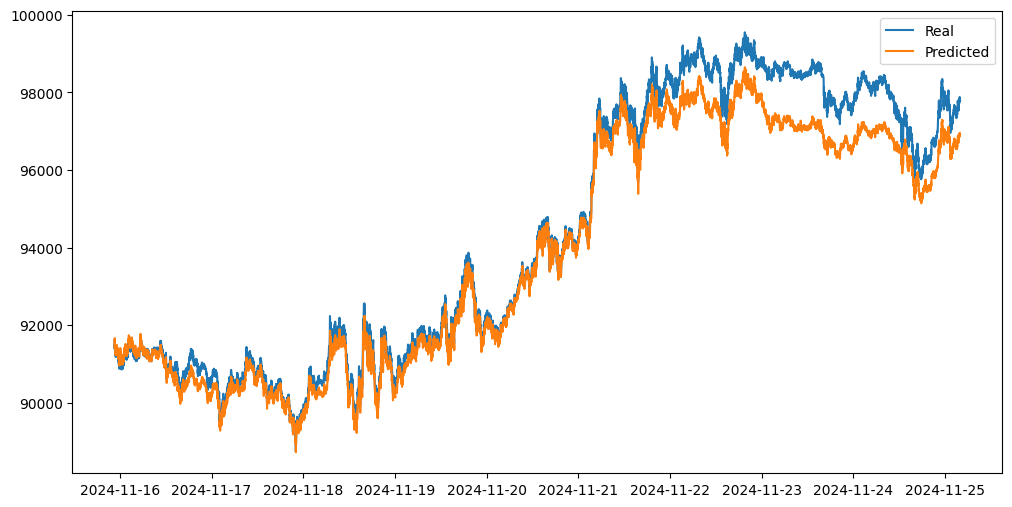

In [21]:
# Evaluar y graficar resultados.
last_price = df_combined.iloc[train_size + val_size + sequence_length - 1]
predicted_price = predicted_price_orig
predicted_price = predicted_price.reshape(-1, 1)
predicted_price = np.hstack([predicted_price, np.zeros(
    (predicted_price.shape[0], X_test.shape[2] - 1))])
predicted_price = scaler.inverse_transform(predicted_price)[:, 0]

y_test_original = y_test
y_test_original = y_test_original.reshape(-1, 1)
y_test_original = np.hstack([y_test_original, np.zeros(
    (y_test_original.shape[0], X_test.shape[2] - 1))])
y_test_original = scaler.inverse_transform(y_test_original)[:, 0]
# y_test_original = last_price.values[0] + np.cumsum(y_test_original)

# predicted_values = [last_price.values[0]]
# for i in range(len(y_test_original) - 1):
#     predicted_values.append(y_test_original[i] + predicted_price[i +1])

# predicted_values = predicted_values[1:]

plt.figure(figsize=(12, 6))
plt.plot(df_combined.index[train_size + val_size + sequence_length:], y_test_original, label='Real')
plt.plot(df_combined.index[train_size + val_size + sequence_length:], predicted_price, label='Predicted')
plt.legend()
plt.show()

In [17]:
# Evaluar el modelo
mse = mean_squared_error(y_test_original , predicted_price)
mae = mean_absolute_error(y_test_original, predicted_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, predicted_price)
mape = np.mean(
    np.abs((y_test_original - predicted_price) / y_test_original)) * 100

# Imprimir las métricas
print(f"Error cuadrático promedio (MSE): {mse:.2f}")
print(f"Error absoluto promedio (MAE): {mae:.2f}")
print(f"Raíz del error cuadrático promedio (RMSE): {rmse:.2f}")
print(f"Coeficiente de determinación (R²): {r2:.2f}")
print(f"Error porcentual absoluto promedio (MAPE): {mape:.2f}%")

Error cuadrático promedio (MSE): 430852.47
Error absoluto promedio (MAE): 495.48
Raíz del error cuadrático promedio (RMSE): 656.39
Coeficiente de determinación (R²): 0.96
Error porcentual absoluto promedio (MAPE): 0.51%


In [18]:
# Parámetros de la estrategia.
threshold = 0
take_profit = 0
stop_loss = 0.2

# Variables para la simulación.
balance = 1 # Balance inicial en USD.
position = None # Estado de la posición actual: 'long', 'short', None.
entry_price = 0 # Precio al que se entra en una posición.
positions = [] # Registro de las operaciones.
lag = 1

# Simulación temporal
for t in range(len(y_test_original) - lag):
    current_price = y_test_original[t]
    future_price = predicted_price[t + lag]

    # Verificar si estamos en posición.
    if position is None:
        # Evaluar si es una entrada larga.
        if future_price > current_price * (1 + threshold):
            position = "long"
            entry_price = current_price
            positions.append({
                "type": "buy",
                "entry_price": entry_price,
                "time": t
            })
        # Evaluar si es una entrada corta.
        elif future_price < current_price * (1 - threshold):
            position = "short"
            entry_price = current_price
            positions.append({
                "type": "sell",
                "entry_price": entry_price,
                "time": t
            })
    else:
        # Calcular el cambio porcentual.
        change = (current_price - entry_price) / entry_price
        if position == "short":
            change = -change
        
        # Salir de la posición si se alcanza take-profit o stop-loss.
        if change >= take_profit or change <= -stop_loss:
            profit_loss = balance * change
            balance += profit_loss
            positions[-1].update({
                "exit_price": current_price,
                "exit_time": t,
                "profit_loss": profit_loss
            })
            position = None

# Convertir posiciones a DataFrame para análisis.
positions_df = pd.DataFrame(positions)
print(balance)
display(positions_df)

1.0337474576148389


,type,entry_price,time,exit_price,exit_time,profit_loss
0,buy,91483.63,0,91633.58,3.0,0.001639
1,buy,91472.01,4,91552.63,218.0,0.000883
2,buy,91465.46,219,91534.12,220.0,0.000753
3,buy,91605.77,221,91660.96,222.0,0.000604
4,buy,91589.16,223,91594.45,229.0,0.000058
5,buy,91619.51,230,91622.80,231.0,0.000036
6,buy,91607.48,232,91759.50,406.0,0.001666
7,buy,91685.19,407,91689.00,3379.0,0.000042
8,sell,91920.01,3380,91916.00,3386.0,0.000044
9,sell,91828.01,3387,91712.00,3388.0,0.001271


In [ ]:
predictions = []
for t in range(len(y_test_original) - lag):
    # Preparar la secuencia actual de entrada.
    current_sequence = X_test[t]
    

In [247]:
# Parámetros de la estrategia.
threshold = 0.004
take_profit = 0.0001
stop_loss = 0.0009

# Variables para la simulación.
balance = 1 # Balance inicial en USD.
position = None # Estado de la posición actual: 'long', 'short', None.
entry_price = 0 # Precio al que se entra en una posición.
positions = [] # Registro de las operaciones.

# Simulación temporal.
for t in range(sequence_length, len(y_test_original)):
    # Preparar la secuencia actual de entrada.
    current_sequence = X_test[t]

    # Ajustar la forma para el modelo.
    current_sequence = np.expand_dims(current_sequence, axis=0)

    print(f"Shape de current_sequence: {current_sequence.shape}")

    # Predecir el precio futuro.
    predicted_price = best_model.predict(current_sequence)[0]

    # Precio actual del mercado.
    current_price = y_test_original[t]

    # Verificar si estamos en posición.
    if position is None:
        # Evaluar si es una entrada larga.
        if future_price > current_price * (1 + threshold):
            position = "long"
            entry_price = current_price
            positions.append({
                "type": "buy",
                "entry_price": entry_price,
                "time": t
            })
        # Evaluar si es una entrada corta.
        elif future_price < current_price * (1 - threshold):
            position = "short"
            entry_price = current_price
            positions.append({
                "type": "sell",
                "entry_price": entry_price,
                "time": t
            })
    else:
        # Calcular el cambio porcentual.
        change = (current_price - entry_price) / entry_price
        if position == "short":
            change = -change
        
        # Salir de la posición si se alcanza take-profit o stop-loss.
        if change >= take_profit or change <= -stop_loss:
            profit_loss = balance * change
            balance += profit_loss
            positions[-1].update({
                "exit_price": current_price,
                "exit_time": t,
                "profit_loss": profit_loss
            })
            position = None

# Convertir posiciones a DataFrame para análisis.
positions_df = pd.DataFrame(positions)
print("Balance final:", balance)
display(positions_df)

Shape de current_sequence: (1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Shape de current_sequence: (1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Shape de current_sequence: (1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Shape de current_sequence: (1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Shape de current_sequence: (1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Shape de current_sequence: (1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Shape de current_sequence: (1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Shape de current_sequence: (1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Shape de current_sequence: (1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Shape de current_sequence: (1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Shape de current_sequence: (1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Shape de current_sequence: (1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Shape de current_sequence: (1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Shape de cur

,type,entry_price,time,exit_price,exit_time,profit_loss
0,buy,42700.12,60,42624.00,61.0,-0.001783
1,buy,42684.88,62,42739.14,63.0,0.001269
2,buy,42856.92,64,43154.48,65.0,0.006940
3,buy,42895.41,66,42806.01,68.0,-0.002098
4,buy,42786.25,69,42870.00,70.0,0.001966
...,...,...,...,...,...,...
391,buy,51680.00,977,51396.33,978.0,-0.006682
392,buy,51324.99,979,51509.89,980.0,0.004362
393,sell,52168.65,984,52258.82,985.0,-0.002100
394,sell,52174.20,986,52102.56,987.0,0.001665
